In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['SETIGEN_ENABLE_GPU'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from astropy import units as u
import blimpy as bl

import setigen as stg

import h5py


In [2]:
%matplotlib inline

In [3]:
def test_configuration(rvb):
    save_file_stem = 'test_v_std1_pols1'
    rvb.record(output_file_stem=save_file_stem,
                num_blocks=1, 
                length_mode='num_blocks',
                header_dict={'TELESCOP': 'GBT'},
                verbose=False)

    !rawspec -f 1024 -t 4 -d . {save_file_stem}
    !fil2h5 {save_file_stem}.rawspec.0000.fil

    h5_comparison1 = h5py.File(f"{save_file_stem}.rawspec.0000.h5")
    h5_comparison1_fildata = h5_comparison1["data"]
    h5_comparison1 = h5_comparison1_fildata[:,0,:]
    h5_comparison1_slice = h5_comparison1[:,2*1024+200:3*1024-200]

    print(h5_comparison1_fildata.shape)
    for k in h5_comparison1_fildata.attrs:
        print(f"{k} = {h5_comparison1_fildata.attrs[k]}")

    print(np.std(h5_comparison1_slice))

    frame = stg.Frame(f"{save_file_stem}.rawspec.0000.h5", 
                    f_start=rvb.get_coarse_freq(2),
                    f_stop=rvb.get_coarse_freq(3))
    frame.plot()
    plt.show()
    stg.spectrum(frame, mode='sum').plot(ftype='f')
    plt.show()

In [4]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=6*u.GHz,
                              ascending=True,
                              num_pols=1,
                              seed=42)

digitizer = stg.voltage.VRefQuantizer(v_ref=16, num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexVRefQuantizer(v_ref=16, num_bits=8)

Blocks:   0%|          | 0/1 [00:00<?, ?it/s]

Blocks: 100%|██████████| 1/1 [01:28<00:00, 88.39s/it]

working stem: test_v_std1_pols1
opening file: test_v_std1_pols1.0000.raw


opening file: test_v_std1_pols1.0001.raw [No such file or directory]
output product 0: 256 spectra
blimpy.waterfall INFO     Detecting intermediate frequency and time resolution data.
blimpy.waterfall INFO     __write_to_hdf5_heavy: For ./test_v_std1_pols1.rawspec.0000.h5, chunk_dim=(10, 1, 65536), blob_dim=(256, 1, 65536), n_blobs=1
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
blimpy.waterfall INFO     __write_to_hdf5_heavy: Processing blob 1 of 1
blimpy.waterfall INFO     Conversion time: 0.62sec
(256, 1, 65536)
DIMENSION_LABELS = ['time' 'feed_id' 'frequency']
az_start = 0.0
data_type = 1
fch1 = 5998.53515625
foff = 0.00286102294921875
ibeam = -1
machine_id = 20
nbeams = 1
nbits = 32
nchans = 65536
nifs = 1
rawdatafile = test_v_std1_pols1.0000.raw
source_name = TMC1
src_dej

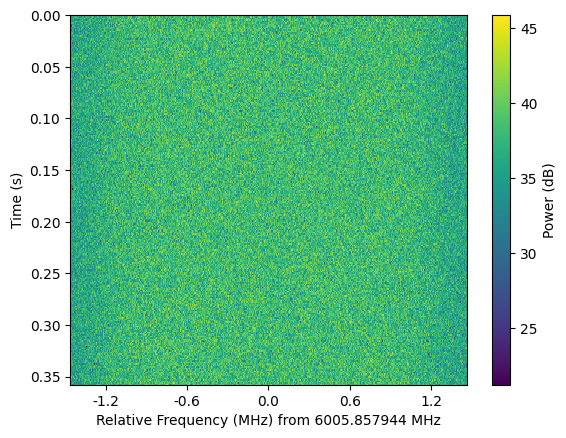

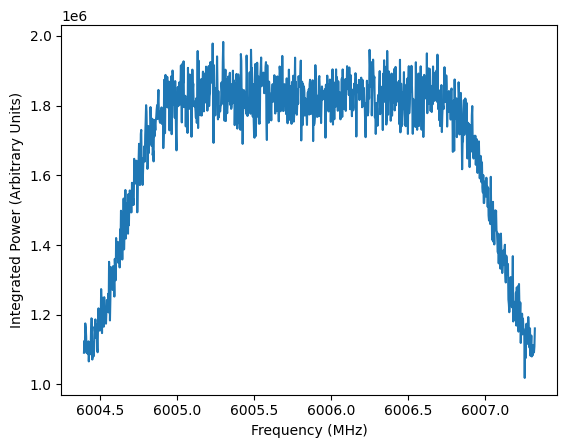

Blocks: 100%|██████████| 1/1 [01:29<00:00, 89.07s/it]

working stem: test_v_std1_pols1
opening file: test_v_std1_pols1.0000.raw


opening file: test_v_std1_pols1.0001.raw [No such file or directory]
output product 0: 256 spectra
blimpy.waterfall INFO     Detecting intermediate frequency and time resolution data.
blimpy.waterfall INFO     __write_to_hdf5_heavy: For ./test_v_std1_pols1.rawspec.0000.h5, chunk_dim=(10, 1, 65536), blob_dim=(256, 1, 65536), n_blobs=1
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
hdf5plugin._filters WARNING  Deprecation: hdf5plugin.Bitshuffle's lz4 argument is deprecated, use cname='lz4' or 'none' instead.
blimpy.waterfall INFO     __write_to_hdf5_heavy: Processing blob 1 of 1
blimpy.waterfall INFO     Conversion time: 0.67sec
(256, 1, 65536)
DIMENSION_LABELS = ['time' 'feed_id' 'frequency']
az_start = 0.0
data_type = 1
fch1 = 5998.53515625
foff = 0.00286102294921875
ibeam = -1
machine_id = 20
nbeams = 1
nbits = 32
nchans = 65536
nifs = 1
rawdatafile = test_v_std1_pols1.0000.raw
source_name = TMC1
src_dej

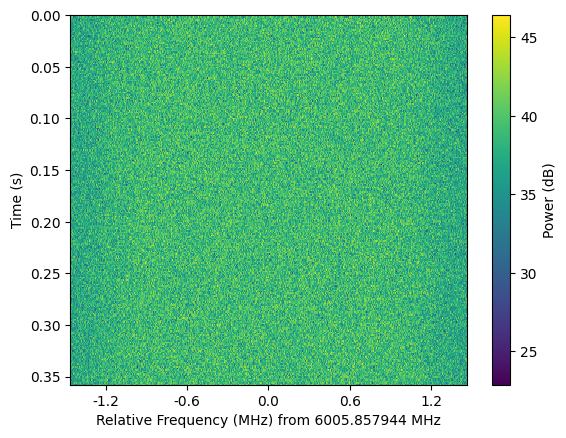

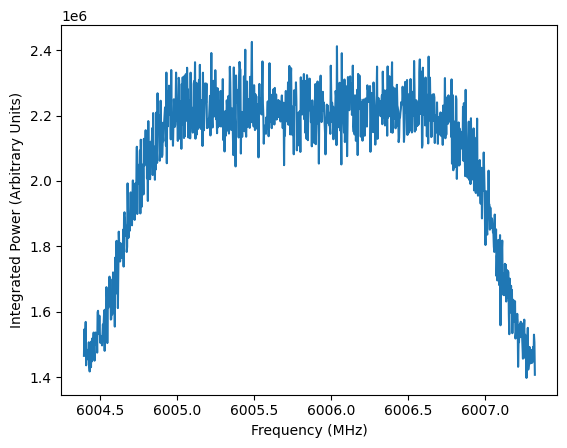

In [5]:
rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=0,
                                    num_chans=64,
                                    block_size=134217728,
                                    blocks_per_file=128,
                                    num_subblocks=32)

for stream in antenna.streams:
    stream.add_noise(v_mean=0, 
                     v_std=1)
    
test_configuration(rvb)

antenna.clear()
for stream in antenna.streams:
    stream.add_noise(v_mean=0, 
                     v_std=5000)
    
test_configuration(rvb)